In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [13]:
from sklearn.datasets import make_circles, make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from spectral_clustering import *

import matplotlib.pyplot as plt

In [3]:
import warnings

warnings.filterwarnings(
    "ignore", message="KMeans is known to have a memory leak on Windows with MKL"
)

In [4]:
X, y = make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=42)

In [5]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
gmm = GaussianMixture(n_components=2, random_state=42)

y_kmeans = kmeans.fit_predict(X)
y_gmm = gmm.fit_predict(X)

In [6]:
distance_matrix = get_distance_matrix_from_data(X)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="knn"
)

spectral_clustering = Spectral_Clustering(W=similarity_matrix, K=2)
y_spectral = spectral_clustering.labels

# Intro

Motivation and example when spectral clustering is better than GMM and K-Means

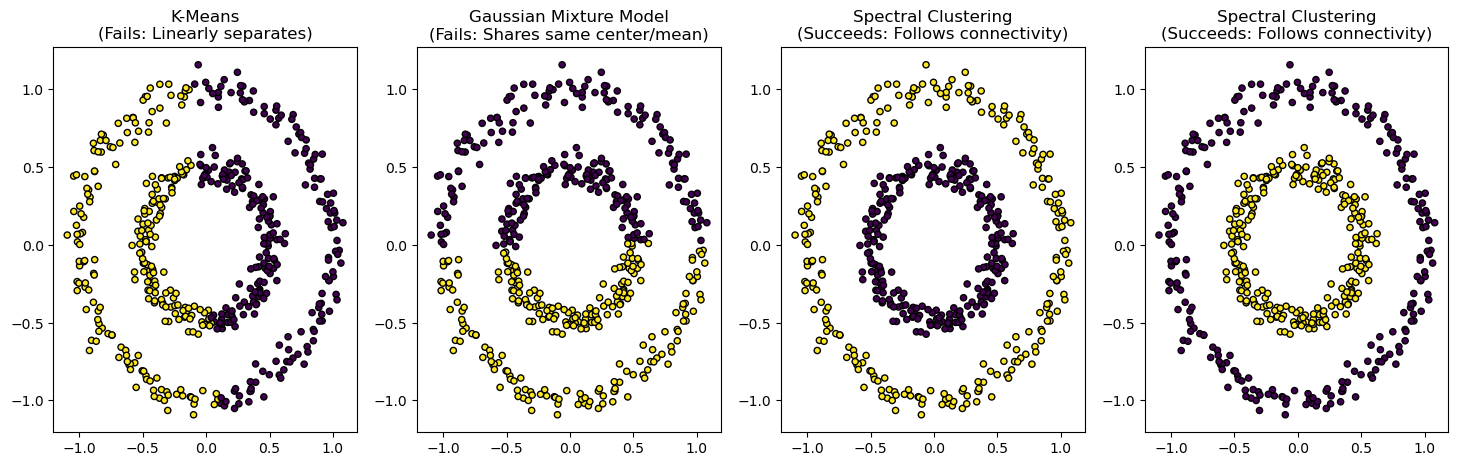

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Plot K-Means
axes[0].scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap="viridis", s=20, edgecolor="k")
axes[0].set_title("K-Means\n(Fails: Linearly separates)")

# Plot GMM
axes[1].scatter(X[:, 0], X[:, 1], c=y_gmm, cmap="viridis", s=20, edgecolor="k")
axes[1].set_title("Gaussian Mixture Model\n(Fails: Shares same center/mean)")

# Plot Spectral
axes[2].scatter(X[:, 0], X[:, 1], c=y_spectral, cmap="viridis", s=20, edgecolor="k")
axes[2].set_title("Spectral Clustering\n(Succeeds: Follows connectivity)")

# Plot
axes[3].scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=20, edgecolor="k")
axes[3].set_title("Spectral Clustering\n(Succeeds: Follows connectivity)")

plt.show()

If we have a look at the representation of the data in the embedded space, then the clusters are located on the coordinate axes. This follows from the fact that eigenvectors are indicators in the optimal case

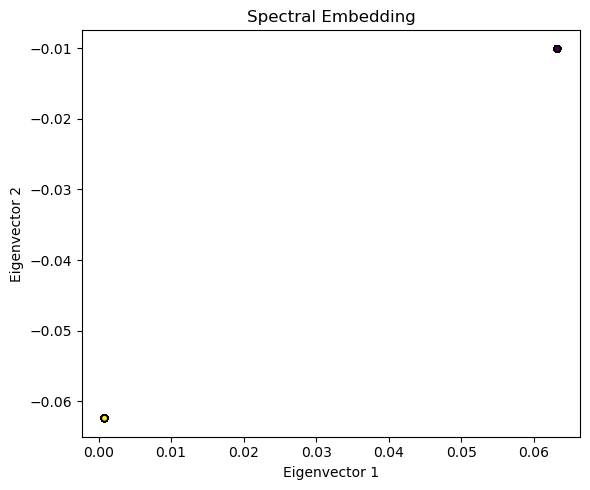

In [8]:
spectral_embedding = spectral_clustering.eigenvectors

plot_2d_spectral_embedding(spectral_embedding, y_spectral)

One can say that we can just engineer a feature that would capture the similarity of the points, e.g., norm of the points, and then run K-Means or GMM. And that is very close to the motivation behind SC. It requires pairwise similarity measures for the data points and if the modelled similarity captures the actual similarity of the data points, the resulting clustering will be very good

# Theoretical Part

## Graph Notation and Similarity
Consider a set of data points $x_1, \dots, x_n$ and a notion of similarity $w_{ij} \geq 0$ between them. We represent this data as an undirected graph $G = (V, E)$, where the vertex set $V = \{v_1, \dots, v_n\}$ represents the data points.

The graph is weighted, where the edge weight $w_{ij} \geq 0$ corresponds to the similarity $w_{ij}$ between points $x_i$ and $x_j$. If $w_{ij} = 0$, the vertices are not connected. Since $G$ is undirected, the weighted adjacency matrix $W = (w_{ij})_{i,j=1,\dots,n}$ is symmetric (i.e., $w_{ij} = w_{ji}$). The greater the weight, the more similar the data points are.

The degree of a vertex $v_i$ is defined as the sum of the weights of its incident edges:

$$
d_i = \sum_{j=1}^{n} w_{ij}
$$

The degree matrix $D$ is defined as the diagonal matrix with the degrees $d_1, \dots, d_n$ on the diagonal.

## Graph Laplacians
Spectral clustering utilizes the properties of graph Laplacian matrices.

### The Unnormalized Graph Laplacian
The unnormalized graph Laplacian matrix is defined as:

$$
L = D - W
$$

### The Random Walk Normalized Laplacian
The random walk normalized graph Laplacian is defined as:

$$
L_{rw} := D^{-1}L = I - D^{-1}W
$$

## Properties and Analysis
The random walk normalized Laplacian $L_{rw}$ satisfies several important properties:

1.  **Spectrum:** $L_{rw}$ is positive semi-definite and has $n$ non-negative real-valued eigenvalues:
    $$
    0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_n
    $$

2. The multiplicity $k$ of the eigenvalue $0$ of $L_{rw}$ equals the number of connected components $A_1, \dots, A_k$ in the graph. 
3. The eigenspace of $0$ for $L_{rw}$ is spanned by the indicator vectors $\mathbb{1}_{A_i}$ of those components.

## Normalized Spectral Clustering Algorithm
The following algorithm describes the normalized spectral clustering method according to Shi and Malik (2000):

**Input:** Similarity matrix $S \in \mathbb{R}^{n \times n}$, number $k$ of clusters to construct.

*   Construct a similarity graph as described in the first section. Let $W$ be its weighted adjacency matrix.
*   Compute the unnormalized Laplacian $L$.
*   Compute the first $k$ generalized eigenvectors $u_1, \dots, u_k$ of the generalized eigenproblem:
    $$
    Lu = \lambda Du
    $$
*   Let $U \in \mathbb{R}^{n \times k}$ be the matrix containing the vectors $u_1, \dots, u_k$ as columns.
*   For $i = 1, \dots, n$, let $y_i \in \mathbb{R}^k$ be the vector corresponding to the $i$-th row of $U$.
*   Cluster the points $(y_i)_{i=1, \dots, n}$ in $\mathbb{R}^k$ with the $k$-means algorithm into clusters $C_1, \dots, C_k$.

**Output:** Clusters $A_1, \dots, A_k$ with $A_i = \{j \mid y_j \in C_i\}$.

# Choice of the Similarity Matrix

The choice of the similarity graph is strongly dependent on the structure of the data and often requires some background knowledge to get a good representation of the similarity of datapoints.

### Epsilon Neighborhood
This method connects all points whose pairwise distance is smaller than $\epsilon$. It generally creates an unweighted graph. It performs well only if the data has a similar scale. If the data lies on a curved manifold or if the density of the data varies significantly across clusters, the fixed $\epsilon$ will either fragment the sparse clusters or over-connect the dense ones.

### K-Nearest Neighbors (KNN)
This method connects vertex $v_i$ to vertex $v_j$ if $v_j$ is among the $k$ nearest neighbors of $v_i$.

*   **Pros:** It is adaptive to local density. It can successfully bridge regions with different densities and connect clusters that are reasonably far apart.
*   **Cons:** It can occasionally bridge two clusters that should be separate if a "bridge" of noise points exists between them.

### Mutual KNN
This method connects $v_i$ and $v_j$ only if they are both among each other's $k$ nearest neighbors.

*   **Pros:** This is a "stricter" condition that acts as a middle ground between epsilon neighborhoods and simple KNN. It tends to remove edges between clusters of different densities, resulting in cleaner separation.
*   **Cons:** It can lead to a disconnected graph with many small isolated components if the $k$ parameter is too small.

### Fully Connected with RBF Kernel
This method connects all points with positive similarity weighted by the Gaussian kernel:

$$
W_{ij} = \exp(-\|x_i - x_j\|^2 / 2\sigma^2)
$$

Mathematically, the Gaussian similarity function acts as the heat kernel. Spectral clustering on this graph can be interpreted as simulating how heat (or a random walker) spreads across the data points. If the algorithm detects a cluster, it identifies a region where heat diffuses quickly within the group but spreads very slowly to the rest of the dataset.

### Conclusion and Recommendation
In practice, KNN is often the first choice; it yields a sparse matrix (efficient computation) and handles variations in data density better than the standard RBF kernel.

However, the Fully Connected RBF graph remains the gold standard for theoretical analysis due to its connection to Heat Diffusion.

Therefore, if the dataset is small enough ($N < 2000$) to handle a dense matrix, the RBF kernel provides the most geometrically faithful representation of the data manifold. For larger or noisy datasets, KNN is preferred for its sparsity and robustness.

In [25]:
# Rafael's plot comparing similarities?

In [26]:
# Parameter Fitting

## Parameters that we need to fit:

*   Metric for the distance matrix;
*   Similarity graph type:
    1.  Fully connected ($\sigma$, bandwidth for the RBF kernel);
    2.  Epsilon neighborhood ($\epsilon$);
    3.  KNN (knn);
    4.  Mutual KNN (mutual knn);
*   $k$, number of clusters;

## Fitting similarity matrix parameters

It is crucial to note that one should not perform a flat grid search across different graph types (e.g., comparing RBF vs. KNN). Instead, the optimization must be hierarchical:

1.  **Select Graph Type:** Manually select the similarity measure (e.g., Fully Connected RBF vs. KNN) based on dataset size and density constraints.
2.  **Define Search Range:** For the fixed graph type, define the range for its specific parameter $\theta$ (e.g., $\sigma \in [0.1, 10]$ for RBF).
3.  **Compute Eigengap:** For each candidate $\theta$:
    1.  Construct the similarity matrix $W_\theta$.
    2.  Connectivity Check: If using KNN or $\epsilon$-neighborhoods, verify that the graph has less connected components than $k$. If the graph is fractured into more components than the desired cluster count $k$, discard this parameter value immediately.
    3.  Compute Laplacian eigenvalues and the gap $\delta_k = |\lambda_{k+1} - \lambda_k|$.
4.  **Selection:** Select the $\theta$ that maximizes $\delta_k$ within this specific graph family.

## Choosing the number of clusters $k$

We choose the number of clusters $k$ such that the first $k$ eigenvalues are very small, while the $(k+1)$-th eigenvalue is relatively large. Mathematically, we maximize the gap:

$$
k^* = \underset{k}{\arg\max} |\lambda_{k+1} - \lambda_k|
$$

In [ ]:
# Parameter choice